In [1]:
from ema import read

%load_ext autoreload
%autoreload 2

In [2]:
meal_info = read.all_meal_info()

/tmp/ipykernel_1451/4258929155.py:58: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


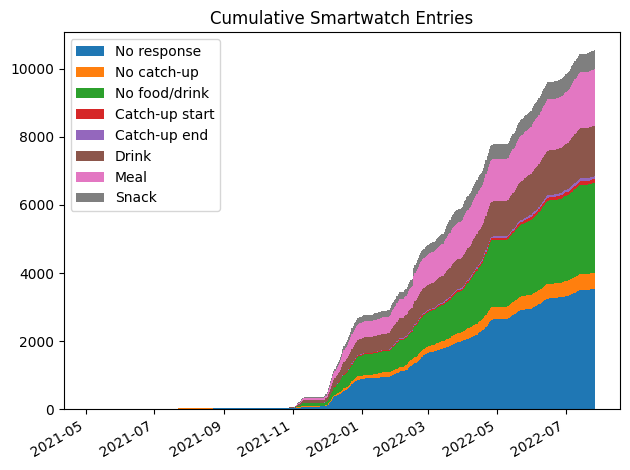

In [3]:
"""
Plot a cumulative histogram showing the number of each type of meal

"""
import pandas as pd
import matplotlib.pyplot as plt


def entry_time_hist(
    meal_timing_df: pd.DataFrame,
    *,
    cumulative: bool = False,
    granularity: str = "1D",
    fig_ax: tuple = None
) -> tuple[plt.Figure, plt.Axes]:
    """
    Plot a histogram of the times of each type of entry in `meal_info`

    :param meal_timing_df: dataframe of smartwatch entries
    :param cumulative: whether to plot a cumulative histogram
    :param granularity: bin granularity; "D", "H", etc. Or bins

    """
    min_time, max_time = meal_info.index.min(), meal_info.index.max()

    fig, axis = plt.subplots() if fig_ax is None else fig_ax
    bins = (
        pd.date_range(min_time, max_time, freq=granularity)
        if isinstance(granularity, str)
        else granularity
    )

    labels = meal_timing_df["meal_type"].unique()
    # Sort the labels
    labels = [
        *[l for l in labels if l.startswith("No ")],
        *[l for l in labels if l.startswith("Catch-up")],
        *labels,
    ]  # Put them in the desired order
    labels = list(dict.fromkeys(labels))  # Remove duplicates, preserve order

    data = [
        meal_timing_df[meal_timing_df["meal_type"] == meal_type].index
        for meal_type in labels
    ]
    axis.hist(data, bins=bins, stacked=True, label=labels, cumulative=cumulative)

    axis.legend()

    fig.autofmt_xdate()
    fig.tight_layout()

    return fig, axis


fig, axis = entry_time_hist(meal_info, cumulative=True)
axis.set_title("Cumulative Smartwatch Entries")
fig.tight_layout()
fig.savefig("img/smartwatch_entries_all.png")

### Data cleaning - remove entries with start dates before the watch collection date
Remove entries where the date is before the watch collection date
(in `SEACO data/Stata Datasets/SEACO-CH20 smartwatch feasibility- for LJ.dta`).

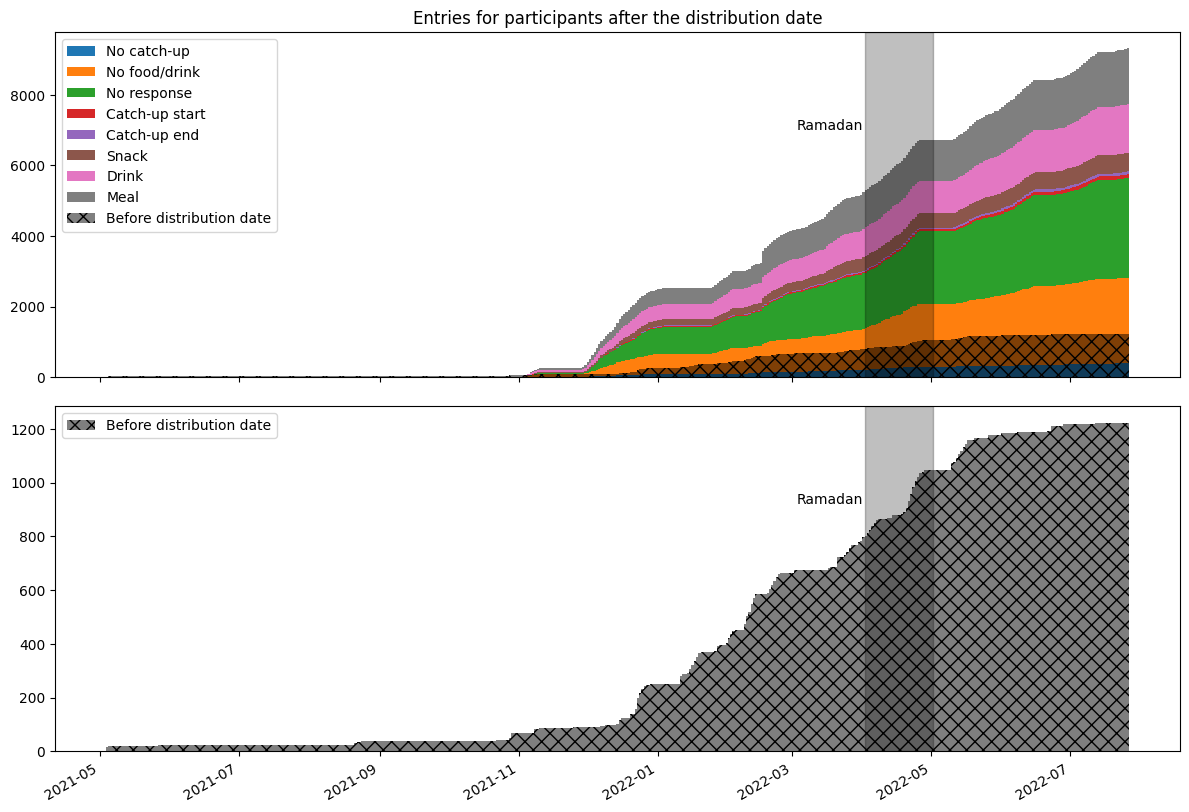

In [4]:
"""
Remove the entries before the watch collection date - these are probably meaningless

"""
# Re read the df to avoid issues with re-running the cell
meal_info = read.all_meal_info()

# Find collection dates for each participant
feasibility_info = read.smartwatch_feasibility()

# We only care about ones who consented to the smartwatch study
feasibility_info = feasibility_info[feasibility_info["smartwatchwilling"] == 1]
feasibility_info = feasibility_info[["residents_id", "actualdateofdistribution1st"]]

# Join dataframes
meal_info = (
    meal_info.reset_index()
    .merge(feasibility_info, left_on="p_id", right_on="residents_id", how="left")
    .set_index(meal_info.index)
)

assert (
    meal_info["actualdateofdistribution1st"].isna().sum() == 0
), "Missing distribution dates"

# Remove entries before the collection date
# TODO - compare only the date; we want to throw away entries from before the collection date
keep = meal_info.index > meal_info["actualdateofdistribution1st"]

# Plot histogram of entries with no collection date
bins = pd.date_range(meal_info.index[0], meal_info.index[-1], freq="1D")

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
entry_time_hist(
    meal_info[keep],
    cumulative=True,
    granularity=bins,
    fig_ax=(fig, axes[0]),
)

# Plot a faded out histogram of entries that are before the collection date
for axis in axes:
    axis.hist(
        meal_info.index[~keep],
        cumulative=True,
        color="k",
        bins=bins,
        alpha=0.5,
        label="Before distribution date",
        hatch="\\\\//",
    )

    axis.legend()

    ymax = axis.get_ylim()[1]
    ramadan_dates = read.ramadan_2022()
    axis.autoscale(enable=False, tight=True)
    axis.fill_between(ramadan_dates, [0, 0], [ymax, ymax], color="k", alpha=0.25)

    axis.text(
        ramadan_dates[0] - pd.Timedelta(days=1),
        0.75 * ymax,
        "Ramadan",
        ha="right",
        va="top",
        color="k",
    )

axes[0].set_title("Entries for participants after the distribution date")
fig.savefig("img/smartwatch_entries_after_distribution.png")

We can also look at how many days before the distribution date these entries occurred

[-150.0, -148.98305084745763, -147.96610169491527, -146.94915254237287, -145.9322033898305, -144.91525423728814, -143.89830508474577, -142.8813559322034, -141.864406779661, -140.84745762711864, -139.83050847457628, -138.8135593220339, -137.79661016949152, -136.77966101694915, -135.76271186440678, -134.74576271186442, -133.72881355932202, -132.71186440677965, -131.6949152542373, -130.67796610169492, -129.66101694915255, -128.64406779661016, -127.62711864406779, -126.61016949152543, -125.59322033898306, -124.57627118644068, -123.5593220338983, -122.54237288135593, -121.52542372881356, -120.50847457627118, -119.49152542372882, -118.47457627118644, -117.45762711864407, -116.4406779661017, -115.42372881355932, -114.40677966101694, -113.38983050847457, -112.37288135593221, -111.35593220338984, -110.33898305084746, -109.32203389830508, -108.30508474576271, -107.28813559322035, -106.27118644067797, -105.2542372881356, -104.23728813559322, -103.22033898305085, -102.20338983050848, -101.18644067

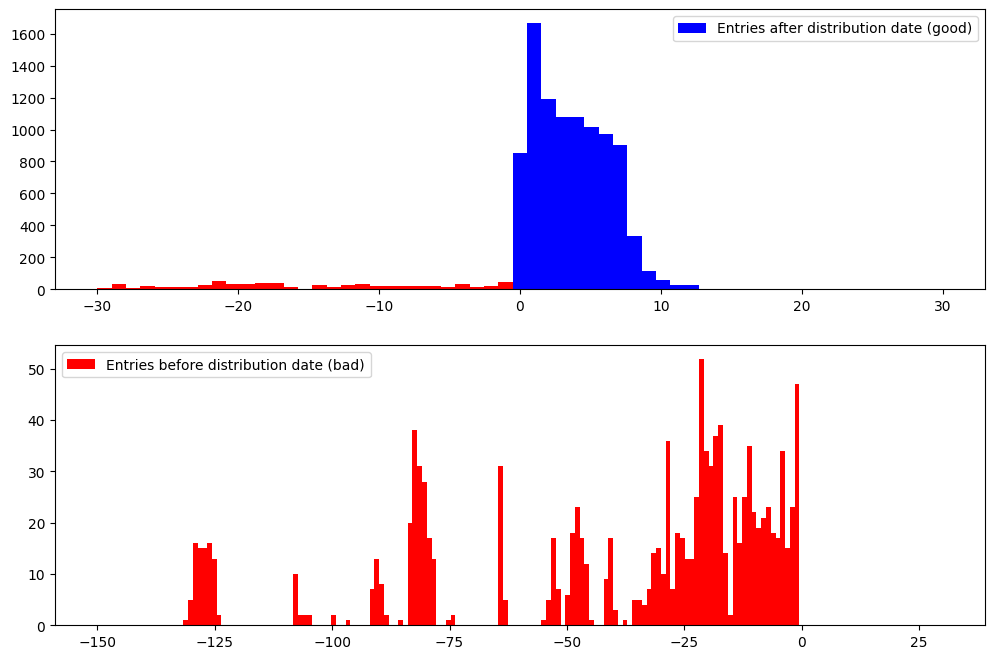

In [5]:
"""
Plot how many days before the distribution date that the bad entries were, then remove them from the dataframe

"""
import numpy as np

# Add a column for how many days after the distribution date the entry was
meal_info["delta"] = (
    meal_info.index.to_series() - meal_info["actualdateofdistribution1st"]
)

# Plot a histogram of this
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

bins = np.linspace(-30, 30, 60)
days = meal_info["delta"].dt.days

axes[0].hist(days, bins=bins, color="r")
axes[0].hist(
    days[days >= 0],
    bins=bins,
    color="b",
    label="Entries after distribution date (good)",
)

bins = sorted(set(np.concatenate([(bins - 120), (bins - 60), bins])))
print(bins)
axes[1].hist(
    days[days < 0], bins=bins, color="r", label="Entries before distribution date (bad)"
)

for axis in axes:
    axis.legend()

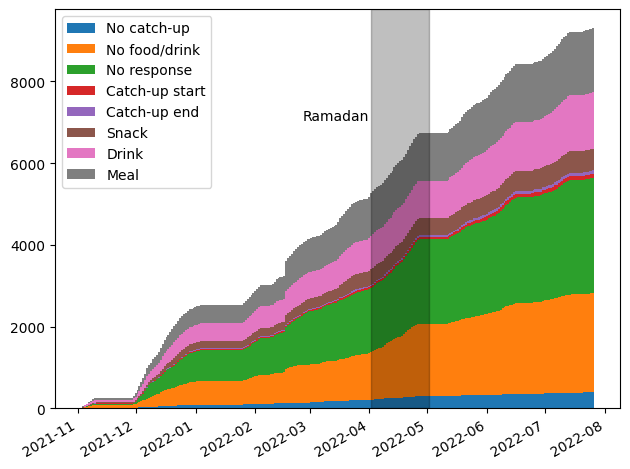

In [6]:
"""
Remove the bad entries and plot histograms again

"""
meal_info = meal_info[meal_info["delta"].dt.days >= 0]

fig, axis = entry_time_hist(
    meal_info,
    cumulative=True,
    granularity="1D",
)

ymax = axis.get_ylim()[1]
axis.text(
    ramadan_dates[0] - pd.Timedelta(days=1),
    0.75 * ymax,
    "Ramadan",
    ha="right",
    va="top",
    color="k",
)
axis.fill_between(ramadan_dates, [0, 0], [ymax, ymax], color="k", alpha=0.25)
axis.set_ylim(0, ymax)

axes[0].set_title("Entries for participants after the distribution date")
fig.savefig("img/smartwatch_entries_after_distribution.png")

### Sanity check
We want to make sure that each participant is entering the same number of entries per day - if they're being asked once per hour then this should presumably add up to 24.

(0.0, 30.0)

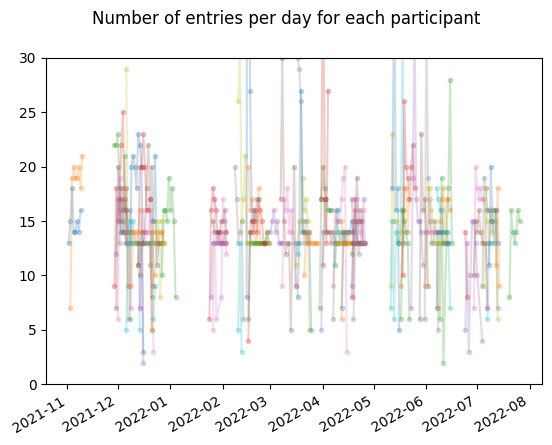

In [42]:
"""
For each participant, find how many entries there were on each day

"""
fig, axis = plt.subplots()

# Let's also build up a dictionary of the number of entries per day per participant
total_participant_entries = {}

plot_kw = {"color": None, "alpha": 0.25, "marker": ".", "linestyle": "-"}
# Iterate over participants
for participant in meal_info["p_id"].unique():
    # For each participant, find how many entries there were on each day of the study
    df_slice = meal_info[meal_info["p_id"] == participant]

    # Get the start date
    assert df_slice.index.is_monotonic_increasing
    start, end = df_slice.index[0].date(), df_slice.index[-1].date()
    dates = np.unique(df_slice.index.date)

    # Iterate over the participation days, finding how many entries were on each day
    entries_per_day = [len(df_slice[df_slice.index.date == date]) for date in dates]

    # Plot a line graph of this
    axis.plot(dates, entries_per_day, **plot_kw)

    total_participant_entries[participant] = sum(entries_per_day)


fig.autofmt_xdate()
fig.suptitle("Number of entries per day for each participant")
axis.set_ylim(0, 30)

In [8]:
"""
Find the fraction of entries on each date that were No response vs meal vs No food

"""
assert False
import numpy as np

# Define bins
n_days = 4
bins = pd.date_range("2021-11-01", "2022-07-15", freq=f"{n_days}D")
centres = bins[1:] - pd.Timedelta(days=n_days / 2)

entries = []
# Find the totals in each bin
for meal_type in [["No response"], ["No food/drink"], ["Snack", "Drink", "Meal"]]:
    df_slice = meal_info[meal_info["meal_type"].isin(meal_type)]

    hist, _ = np.histogram(df_slice.index, bins=bins)
    entries.append(hist)

# Find the fractions and their errors
entries = np.array(entries)
total = np.sum(entries, axis=0)

errs = np.sqrt(entries * total / (entries + total))

no_response, no_food, yes_food = entries / total


def frac_err(a, b):
    return np.sqrt((a * b) / (a + b))


no_response_err = frac_err(no_response, total) / total
yes_food_err = frac_err(yes_food, total) / total
no_food_err = frac_err(no_food, total) / total


# Plot the fractions
def plot_with_err(axis, x, y, y_err, *, label, **kwargs):
    _, caps, bars = axis.errorbar(x, 100 * y, **kwargs, label=label, yerr=100 * y_err)

    # Removed these for now
    alpha = 0.0
    [bar.set_alpha(alpha) for bar in bars]
    [cap.set_alpha(alpha) for cap in caps]

    axis.fill_between(x, 100 * (y + y_err), 100 * (y - y_err), alpha=alpha, **kwargs)

    axis.set_ylabel(f"{label} / %")


fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 8), gridspec_kw={"hspace": 0})


plot_with_err(
    axes[0], centres, no_response, no_response_err, color="b", label="No response"
)
plot_with_err(
    axes[1], centres, yes_food, yes_food_err, color="k", label="Food Recorded"
)
plot_with_err(
    axes[2], centres, no_food, no_food_err, color="g", label="No food Recorded"
)

for axis in axes[:3]:
    axis.set_ylim(0, 100)
    axis.legend()

entry_time_hist(meal_info, cumulative=False, granularity=bins, fig_ax=(fig, axes[3]))
axes[3].get_legend().remove()

# Indicate Ramadan
for axis in axes:
    ylim = axis.get_ylim()
    axis.fill_between(read.ramadan_2022(), [0, 0], [ylim[1]] * 2, color="k", alpha=0.25)
    axis.set_ylim(ylim)

# Remove the first tick label
for axis in axes[:3]:
    axis.set_yticklabels(
        [label if i else "" for (i, label) in enumerate(axis.get_yticklabels())]
    )

_ = fig.autofmt_xdate()

fig.savefig("img/response_fraction.png")

AssertionError: 

Perhaps instead we care about what day of the study the participant was on, instead of the day in the year...

In [ ]:
import numpy as np

assert False
# Find each unique user
p_ids = meal_info["p_id"].unique()

# Find the first date for each participant
first_dates = []
for p_id in p_ids:
    dates = pd.unique(meal_info[meal_info["p_id"] == p_id]["firstdate"])
    assert len(dates) == 1, f"Multiple first dates for participant {p_id}"

    first_dates.append(pd.to_datetime(dates[0], format=r"%d %b %y"))

first_dates = pd.Series(first_dates)

# build up a matrix of participant ids and non-response rate
non_response_matrix = np.ones((len(p_ids), 8)) * np.nan
response_matrix = np.ones((len(p_ids), 8)) * np.nan

# For each participant, find the non-response rate for each of the eight days following their first recording
for p_id, start_date, non_response_row, response_row in zip(
    p_ids, first_dates, non_response_matrix, response_matrix
):
    # Slice the dataframe to find the meals recorded by this participant
    this_participant = meal_info[meal_info["p_id"] == p_id]

    # Find the non-response rate for each day
    for i in range(8):
        date = start_date + pd.Timedelta(days=i)
        this_date = this_participant[this_participant.index.date == date.date()]

        # Find the number of "no response" entries
        negative_response = ["No response"]
        n_no_response = np.sum(this_date["meal_type"].isin(negative_response))

        non_response_row[i] = n_no_response

        # Find the number of "Drink", "Meal", "Snack", "No food/drink" entries
        positive_response = ["Drink", "Meal", "Snack", "No food/drink"]
        n_response = np.sum(this_date["meal_type"].isin(positive_response))

        response_row[i] = n_response

        # Error if there's anything else
        ignore_response = ["No catch-up", "Catch-up start", "Catch-up end"]
        assert (
            this_date["meal_type"]
            .isin(ignore_response + positive_response + negative_response)
            .values.all()
        ), "Unexpected meal type encountered"